<a href="https://colab.research.google.com/github/Tasleem1027/GENERATIVE_AI/blob/main/GAN_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow.keras import layers

import numpy as np

import matplotlib.pyplot as plt

#Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype("float32") / 255.0

X_train = np.expand_dims(X_train, axis=-1) # shape (28, 28, 1)

BUFFER_SIZE = 60000

BATCH_SIZE = 128

LATENT_DIM = 100 # dimension of random noise

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(LATENT_DIM,)),
        layers.Dense(7*7*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="sigmoid")
    ])
    return model

In [3]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

In [4]:
# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define Loss Functions
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [7]:
EPOCHS = 5

NOISE_DIM = 100 # Use the same LATENT_DIM for consistency

NUM_EXAMPLES = 16

seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    #Gradient tape for both models
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

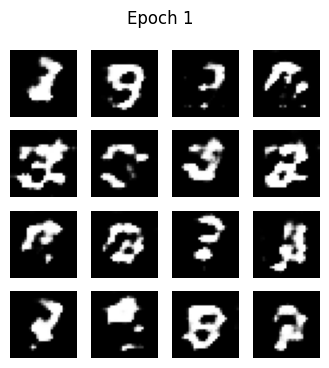

Epoch 1 completed.


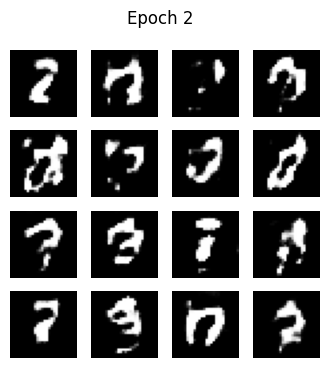

Epoch 2 completed.


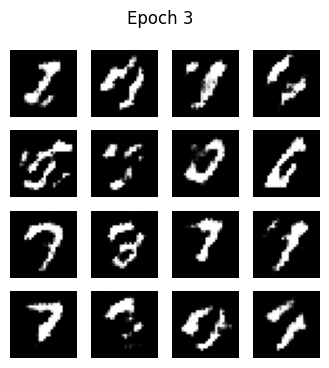

Epoch 3 completed.


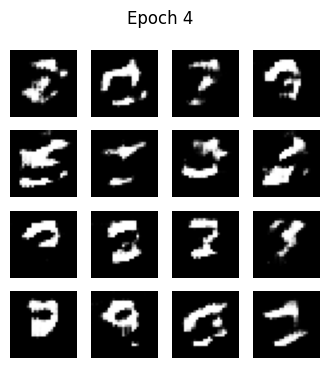

Epoch 4 completed.


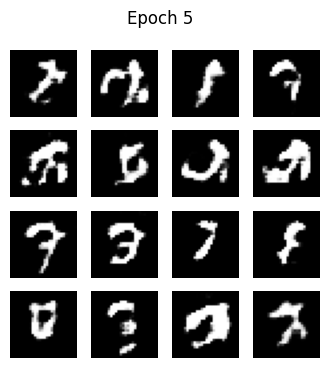

Epoch 5 completed.


In [8]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Generate and save images every epoch
        generate_and_save_images(generator, epoch + 1, seed)
        print(f"Epoch {epoch + 1} completed.")

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.show()

# Run Training
train(dataset, EPOCHS)